# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [2]:
# Создадим константу для фиксации случайной последовательности
MY_RANDOM_STATE=12345

In [3]:
# Уберем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# Вижу избыточные колонки - это: 
# RowNumber: дублирует index
# Surname, CustomerId: уход клиента не может зависеть от его id в банковской системе (тем более от фамилии)
# Удалим избыточные колонки:
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)

In [6]:
# Оставшиеся колонки переименуем для дальнейшего удобства:
data.columns = [
    'credit_score',
    'geography',
    'gender',
    'age',
    'tenure',
    'balance',
    'number_of_products',
    'has_credit_card',
    'is_active_member',
    'estimate_salary',
    'exited'
]

## 1.1 Проверим данные в колонках (заполнение, аномалии)

In [7]:
np.sort(data['credit_score'].unique())

array([350, 351, 358, 359, 363, 365, 367, 373, 376, 382, 383, 386, 395,
       399, 401, 404, 405, 407, 408, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
       521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
       547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
       560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 57

In [8]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [9]:
data['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [10]:
np.sort(data['age'].unique())

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       88, 92])

In [11]:
# В колонке tenure есть пустые значения. 
# Можно предположить, что если tenure не указано, значит недвижимости у клиента нет.
data.loc[data['tenure'].isnull(), 'tenure'] = 0
data['tenure'].value_counts().sort_index()

0.0     1291
1.0      952
2.0      950
3.0      928
4.0      885
5.0      927
6.0      881
7.0      925
8.0      933
9.0      882
10.0     446
Name: tenure, dtype: int64

In [12]:
data['balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64

In [13]:
data['number_of_products'].value_counts().sort_index()

1    5084
2    4590
3     266
4      60
Name: number_of_products, dtype: int64

In [14]:
data['has_credit_card'].value_counts().sort_index()

0    2945
1    7055
Name: has_credit_card, dtype: int64

In [15]:
data['is_active_member'].value_counts().sort_index()

0    4849
1    5151
Name: is_active_member, dtype: int64

In [16]:
data['exited'].value_counts().sort_index()

0    7963
1    2037
Name: exited, dtype: int64

In [17]:
# Используя "прямое кодирование" (OHE) заменим категориальные признаки в колонках geography, gender
if (('geography' and 'gender') in data.columns.tolist()):
    data = pd.get_dummies(data, columns=['geography', 'gender'], drop_first=True)

Разделим исходную выборку:

In [18]:
# Создаем train, valid и test выборки (3:1:1)
features = data.drop('exited', axis=1)
target = data['exited']

# Сначала выделяем тестовую выборку _test
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=MY_RANDOM_STATE)

# То что осталось делим на тренировочную и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=MY_RANDOM_STATE)

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


In [19]:
# Проведем масштаблирование для численных признаков (не трогаем те, которые принимают значения 0 или 1)
numeric = ['credit_score', 'age', 'tenure', 'balance', 'number_of_products', 'estimate_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train_valid[numeric] = scaler.transform(features_train_valid[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

По итогам мы не выявили каких-либо аномалий в данных. Также мы подготовили данные для дальнейших исследований:
* заменили категориальные признаки численными, используя прямое кодирование
* выполнили масштабирования для численных признаков

# 2. Исследование задачи

Проверим баланс классов в целевом признаке <code>exited</code>

In [20]:
# Реализуем отдельную процедуру для проверки баланса классов в целевом признаке
def print_ratio_zeros_ones(target):
    n_zeros = target[target == 0].shape[0]
    n_ones = target[target == 1].shape[0]
    print('0:', n_zeros)
    print('1:', n_ones)
    if (n_zeros < n_ones):
        print('ratio:', 1, ':', n_ones / n_zeros)
    else:
        print('ratio:', n_zeros / n_ones, ':', 1)

# Проверим, что мы имеем в трейне
print('train')
print_ratio_zeros_ones(target_train)

print()

# Для контроля проверим также соотношение классов в исходном датасете
print('data')
n_zeros = data.query('exited == 0').shape[0]
n_ones = data.query('exited == 1').shape[0]
print('0:', n_zeros)
print('1:', n_ones)
print(n_zeros / n_ones)

train
0: 4781
1: 1219
ratio: 3.922067268252666 : 1

data
0: 7963
1: 2037
3.9091801669121256


Классы явно не сбалансированы. "0" больше чем "1" почти в 4 раза.

Пока продолжим изучением данных без учета дизбаланса. Сейчас (и далее уже после борьбы с дисбалансом) будем использовать модель случайный лес (DecisionTreeClassifier).

In [21]:
# Сразу зафиксируем множитель для дальнейшей борьбы с дисбалансом
SAMPLING_MULTIPLIER = 4

In [22]:
# Подберем оптимальное значение гиперпараметра max_depth для модели с 20 деревьями
optimal_depth = 0
f1_basic = 0

for depth in range(1, 21, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=MY_RANDOM_STATE)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > f1_basic:
        optimal_depth = depth
        f1_basic = f1
        
print(optimal_depth, f1_basic)

18 0.5585023400936038


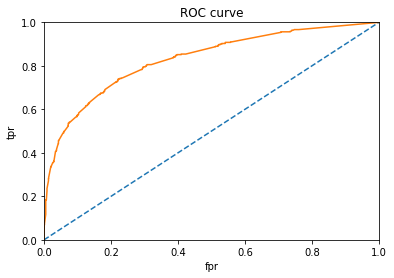

0.8296013949666121


In [23]:
model = RandomForestClassifier(n_estimators=20, max_depth=optimal_depth, random_state=MY_RANDOM_STATE)
model.fit(features_train, target_train)

# Для удобства реализуем процедуру, которая для указанной обученной модели:
# - возвращает значение метрики AUC-ROC
# - строит график ROC-кривой (если print_plot = True)
def get_roc_auc_and_print_roc_plot(model, features, target, print_plot):
    proba = model.predict_proba(features)
    proba_ones = proba[:, 1]
    
    if (print_plot):
        fpr, tpr, thresholds = roc_curve(target, proba_ones)
        plt.figure()
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(fpr, tpr)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC curve')
        plt.show()
    
    return roc_auc_score(target, proba_ones)

roc_auc_basic = get_roc_auc_and_print_roc_plot(model, features_valid, target_valid, True)
print(roc_auc_basic)

Дополнительно проверим результаты, которые можно получить **логистической регрессией**. Классификацию деревом решений опускаю, т.к. одно дерево явно не может тягаться с лесом.

0.3056603773584906


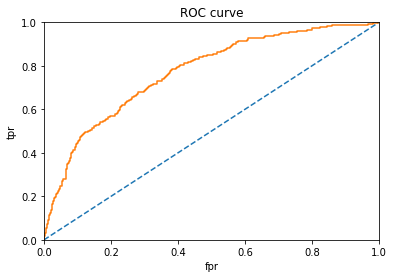

0.7708334989087915


In [24]:
model = LogisticRegression(random_state=MY_RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_log_reg = f1_score(target_valid, predicted_valid)
print(f1_log_reg)

roc_log_reg = get_roc_auc_and_print_roc_plot(model, features_valid, target_valid, True)
print(roc_log_reg)

### Вывод

Даже с 20 деревьями **в случайном лесе**, даже без борьбы с дисбалансом метрика F1 показала значение более 0,59. Ранее мы выяснили, что в целевом признаке класс "1" встречается в 4 раза реже, чем "0". Применим известные нам методы для орьбы с дисбалансом и посмотрим, изменится ли метрика F1.

Модель **логистической регрессии** не выдержала конкуренции. Полученные метрики меньше чем у случайного леса: например, f1 - 0,59 против 0,33. 

Далее при работе будем использовать только модель **случайный лес**.

# 3. Борьба с дисбалансом

Применим 3 изученных метода для борьбы с дисбалансом:
* Взвешивание классов
* Увеличение выборки
* Уменьшение выборки
и сравним результаты

### 3.1 Взвешивание классов

Взвешивание классов
0.5333333333333333


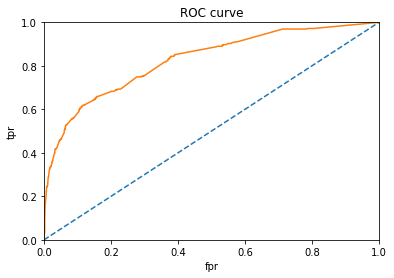

0.8259939693444324


In [25]:
# В модель добавим гиперпараметр class_weight
print('Взвешивание классов')

model = RandomForestClassifier(n_estimators=20, max_depth=optimal_depth, random_state=MY_RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_balanced_classes = f1_score(target_valid, predicted_valid)
print(f1_balanced_classes)

roc_auc_balanced_classes = get_roc_auc_and_print_roc_plot(model, features_valid, target_valid, True)
print(roc_auc_balanced_classes)

### Подготовим выборки для upsampling и downsampling

In [26]:
# В дальнейшем нам понадобится неоднократно повторять upsampling, 
# когда мы будем подбирать оптимальные параметры модели.
# Предусмотрим отдельную процедуру
def apply_sampling(features, target, updown):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    if (updown == 'up'):
        features_upsampled = pd.concat([features_zeros] + SAMPLING_MULTIPLIER * [features_ones])
        target_upsampled = pd.concat([target_zeros] + SAMPLING_MULTIPLIER * [target_ones])
        features_upsampled, target_upsampled = shuffle(
            features_upsampled, target_upsampled, random_state=MY_RANDOM_STATE)
        return features_upsampled, target_upsampled
    else:
        features_downsampled = pd.concat(
            [features_zeros.sample(frac=1/SAMPLING_MULTIPLIER, random_state=MY_RANDOM_STATE)] + [features_ones])
        target_downsampled = pd.concat(
            [target_zeros.sample(frac=1/SAMPLING_MULTIPLIER, random_state=MY_RANDOM_STATE)] + [target_ones])
        features_downsampled, target_downsampled = shuffle(
            features_downsampled, target_downsampled, random_state=MY_RANDOM_STATE)
        return features_downsampled, target_downsampled
        

# И выполним up и down
features_train_upsampled, target_train_upsampled = apply_sampling(features_train, target_train, "up")
features_train_downsampled, target_train_downsampled = apply_sampling(features_train, target_train, "down")

<font color=green>Получились близкие пропорции, молодец.

In [27]:
# Проверим ушел ли дисбаланс классов
print('upsampling')
print_ratio_zeros_ones(target_train_upsampled)
print()
print('downsampling')
print_ratio_zeros_ones(target_train_downsampled)

upsampling
0: 4781
1: 4876
ratio: 1 : 1.019870320016733

downsampling
0: 1195
1: 1219
ratio: 1 : 1.0200836820083683


Выборки подготовлены: соотношение "0" и "1" стало примерно 1 к 1.

### 3.2 Увеличение выборки

upsampling
0.5583333333333333


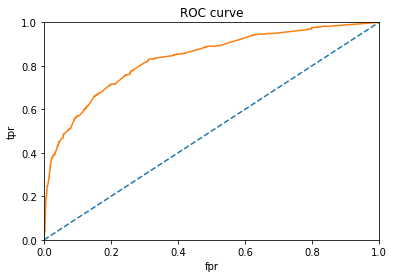

0.8330427152891584


In [28]:
model = RandomForestClassifier(n_estimators=20, max_depth=optimal_depth, random_state=MY_RANDOM_STATE)

print('upsampling')
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
f1_upsampling = f1_score(target_valid, predicted_valid)
print(f1_upsampling)

roc_auc_upsampling = get_roc_auc_and_print_roc_plot(model, features_valid, target_valid, True)
print(roc_auc_upsampling)

In [29]:
# !!! удалить
predicted_test = model.predict(features_test)
f1_111 = f1_score(target_test, predicted_test)
print(f1_111)

0.5905006418485238


### 3.3 Уменьшение выборки

downsampling
0.5516569200779726


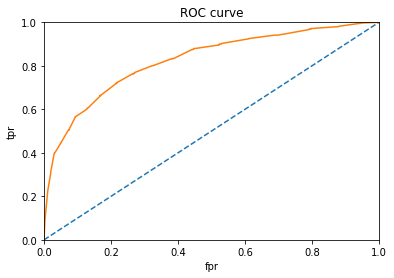

0.8255099591651182


In [30]:
print('downsampling')
model.fit(features_train_downsampled, target_train_downsampled)
predicted_valid = model.predict(features_valid)
f1_downsampling = f1_score(target_valid, predicted_valid)
print(f1_downsampling)

roc_auc_downsampling = get_roc_auc_and_print_roc_plot(model, features_valid, target_valid, True)
print(roc_auc_downsampling)

Собираем все полученные метрики для модели **"случайный лес с 20 деревьями"** в одну таблицу:

In [31]:
print('*** случайный лес с 20 деревьями ***')
print('|{:<20}|{:<10}|{:<10}|'.format('модель', 'F1', 'ROC-AUC'))
print('|{:<20}|{:>10.4f}|{:>10.4f}|'.format('с дисбалансом', f1_basic, roc_auc_basic))
print('|{:<20}|{:>10.4f}|{:>10.4f}|'.format('взвешивание классов', f1_balanced_classes, roc_auc_balanced_classes))
print('|{:<20}|{:>10.4f}|{:>10.4f}|'.format('upsampling', f1_upsampling, roc_auc_upsampling))
print('|{:<20}|{:>10.4f}|{:>10.4f}|'.format('downsampling', f1_downsampling, roc_auc_downsampling))

*** случайный лес с 20 деревьями ***
|модель              |F1        |ROC-AUC   |
|с дисбалансом       |    0.5585|    0.8296|
|взвешивание классов |    0.5333|    0.8260|
|upsampling          |    0.5583|    0.8330|
|downsampling        |    0.5517|    0.8255|


В итоге:
* Максимальное значение метрики F1 было достигнуто для модели с предварительным преобразованием выборки методом увеличения выборки. Выберем эту модель для финального тестирования
* Значение метрики ROC-AUC практически не менялось и даже для несбалансированной модели и после борьбы с дисбалансом

Далее мы сделаем:
1. Сначала с помощью **подбора по сетке** (кросс-валидации) найдем лучшие параметры для для достижения максимального значения метрики f1.
2. К сожалению, типовая кросс-валидация не умеет делать дополнительный upsampling тренировочной выборки (не нашел как). Поэтому мы напишем **свою процедуру кросс-валидации**, которую можно будет использовать вместе с борьбой с дисбалансом.
3. Для контроля корректности работы новой процедуры сначала **запустим ее без upsampling и сравним результаты с п.1**
4. **Запустим процедуру с upsampling** и посмотрим, что получится.

Для того, чтобы было корректно сравнивать результаты пп. 1 и 3 необходимо иметь одинаковые разбиения выборки. Это возможно с использованием метода KFold.

In [40]:
# Зафиксируем сетку, по которой будет выполняться проверка
grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(20, 61, 10),
    'max_depth': range(10, 21, 2),
    'min_samples_split': range(2, 5, 1),
    'min_samples_leaf': range(1, 4, 1)
}

In [41]:
# Для себя проверяю и демонстрирую работу KFold
df = pd.DataFrame({
    'x': [0,1,2,3,4,5,6,7,8,9],
    'y': [0,10,20,30,40,50,60,70,80,90]
})
x = df.drop('y', axis=1)
y = df['y']

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=MY_RANDOM_STATE)
for train_index, valid_index in kfold.split(x):
    print(train_index, valid_index)
# далее сделать срез в x и у по массиву индексов можно например так: x.loc[train_index]

[2 3 4 5 6 7 8 9] [0 1]
[0 1 4 5 6 7 8 9] [2 3]
[0 1 2 3 6 7 8 9] [4 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]


In [42]:
# Перед тем как запускать метод KFold надо сделать reset_index для features и target,
# чтобы потом по полученным через KFold.split() индексам (а по факту номерам строк, а не индексам) 
# смогли безошибочно получить строки таблиц
features_train_valid = features_train_valid.reset_index(drop=True)
target_train_valid = target_train_valid.reset_index(drop=True)

In [43]:
%%time

model = RandomForestClassifier(random_state=MY_RANDOM_STATE)
# Обращаю внимание, что при разбиении используем созданную ранее kfold
gs = GridSearchCV(model, grid, scoring='f1', cv=kfold)
gs.fit(features_train_valid, target_train_valid)
print(gs.best_score_)
print(gs.best_params_)

0.5864218602205642
{'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 30}
CPU times: user 19min 58s, sys: 2.38 s, total: 20min
Wall time: 20min 2s


In [44]:
# Теперь реализуем свою кросс-валидацию
def GridSearchCV_with_sampling(features, target, kfold, updown):
    
    best_estimator = 0
    best_score = 0
    
#     Для каждой модели из декартова произведения всех моделей по сетке параметров
#     определим лучшее значение метрики f1
    for criterion in grid['criterion']:
        for n_estimators in grid['n_estimators']:
            for max_depth in grid['max_depth']:
                for min_samples_split in grid['min_samples_split']:
                    for min_samples_leaf in grid['min_samples_leaf']:
                        
                        model = RandomForestClassifier(random_state=MY_RANDOM_STATE,
                                                       criterion=criterion,
                                                       n_estimators=n_estimators,
                                                       max_depth=max_depth,
                                                       min_samples_split=min_samples_split,
                                                       min_samples_leaf=min_samples_leaf
                                                      )
                        
                        f1_scores = []
                        
                        for train_index, valid_index in kfold.split(features):
                            x_train = features.loc[train_index]
                            x_valid = features.loc[valid_index]
                            y_train = target.loc[train_index]
                            y_valid = target.loc[valid_index]
                            
                            if (updown == 'up'):
                                x_train, y_train = apply_sampling(x_train, y_train, 'up')
                            elif (updown == 'down'):
                                x_train, y_train = apply_sampling(x_train, y_train, 'down')
                            
                            model.fit(x_train, y_train)
                            p_valid = model.predict(x_valid)
                            f1_scores.append(f1_score(y_valid, p_valid))
                            
#                         находим среднее значение метрики по набору разбиений
#                         и если оно лучше, чем найденное раньше сохраняем модель и метрику
                        f1_mean = sum(f1_scores) / len(f1_scores)
                        if (f1_mean > best_score):
                            best_score = f1_mean
                            best_estimator = model
    
    return best_estimator, best_score

In [45]:
%%time

# для своей кросс-валидации используем то же разбиение kfold
best_estimator, best_score = GridSearchCV_with_sampling(features_train_valid, target_train_valid, kfold, '')
print(best_score)
print(best_estimator.get_params())

0.5864218602205643
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
CPU times: user 20min 16s, sys: 2.36 s, total: 20min 19s
Wall time: 20min 25s


В ручном режиме и с помощью типовой процедуры мы получили один и тот же результат, значит наша **ручная кросс-валидация работает корректно**. Теперь **используем ее вместе с upsampling**.

In [46]:
%%time

best_estimator, best_score = GridSearchCV_with_sampling(features_train_valid, target_train_valid, kfold, 'up')
print(best_score)
print(best_estimator.get_params())

0.6121655979458481
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
CPU times: user 29min 42s, sys: 3.14 s, total: 29min 45s
Wall time: 30min 10s


В итоге мы подобрали лучшие параметры (в рамках заданой сетки параметров) для модели случайный лес. Также мы видим, что ожидаемо подбор по сетке вкупе с борьбой с балансом работает лучше, что только подбор по сетке. Применим модель для тестовой выборки.

# 4. Тестирование модели

Итак в предыдущей ячейке мы получили лучшую модель. Сейчас она хранится в переменной `best_estimator`. Применим ее для тестовой выборки.

0.631236442516269


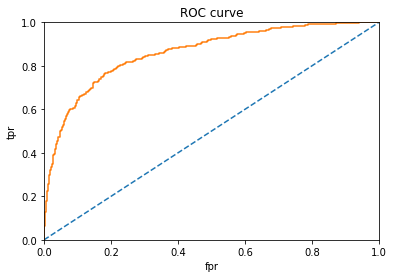

0.861246056477055


In [47]:
model = best_estimator
predicted_test = model.predict(features_test)
f1_final = f1_score(target_test, predicted_test)
print(f1_final)

roc_auc_final = get_roc_auc_and_print_roc_plot(model, features_test, target_test, True)
print(roc_auc_final)

**Нужный показатель метрики F1 достигнут (0,6312 против требуемых 0,62)**